# Temporary Notebook for the SETAR-Tree and Forest Forecaster

This notebook serves as a demonstration to the implementation of the **SETAR-Tree** and **SETAR-Forest**, a novel algorithm for global time series forecasting introduced in the paper "SETAR-Tree: a novel and accurate tree algorithm for global time series forecasting" by Godahewa, R., et al..

The purpose of this notebook is to illustrate the concepts in the research paper and the Python code. I will cover two main areas:
1.  **How the Code Implements the Algorithm**: A step-by-step breakdown of the key methods in the `SetartreeForecaster` class, with direct references to the paper's descriptions and formulas.
2.  **Simple Usage Examples**: Demonstrations of how to fit the model and make predictions on toy datasets. (future: real datasets)

## 1. Brief Introduction of the SETAR-Tree Algorithm

The SETAR-Tree algorithm introduces a global time series forecasting model that is trained globally across multiple series. It stands out from traditional univariate forecasting models through two key innovations in its tree structure: 

#### 1: Pooled Regression (PR) in Leaf Nodes
Instead of simply averaging the training values that fall into a leaf node, the SETAR-Tree fits a **Pooled Regression (PR)** model in each leaf. A PR model is a global linear autoregressive model, which allows each leaf to learn from the cross-series information present in the data that falls into that specific regime.

####  2: Time-Series Specific Splitting and Stopping
The tree's growth is not determined by generic criteria. Instead, it uses methods from threshold modeling:
* **Splitting**: The algorithm finds the optimal past **lag** and **threshold** to partition the data, based on the concepts of Self Exciting Threshold Autoregressive (SETAR) models.
* **Stopping**: The tree's depth is controlled automatically by conducting a statistical **linearity test** and measuring the **error reduction percentage** at each potential split. This greatly reduces the need for manual hyperparameter tuning.

This notebook will now show how these concepts are implemented in the `SetartreeForecaster` class.

In [1]:
# 2. Setup: The SetartreeForecaster Class and Imports

import matplotlib.pyplot as plt
import numpy as np

from aeon.forecasting import SetartreeForecaster

## 3. The `fit` Process

Let's break down the main steps of the fitting process and see how the code handles them.

### Step 3.1: Prepare the Data (`_create_input_matrix`)
The first step is to convert the raw time series data into a feature matrix `X` (the lags) and a target vector `y` (the value to be predicted). When multiple time series are provided, they are "pooled" into a single, large training set. This is the foundation of a global model. 

Let's see this in action with two simple time series.

In [2]:
# Create two simple time series
y1 = np.array([10, 12, 15, 11, 9])
y2 = np.array([50, 55, 48, 51, 56])
y_train_multi = np.vstack([y1, y2])

# Instantiate the forecaster with a small lag
model = SetartreeForecaster(lag=2)

# Use the method to create the input matrix
X, y_target = model._create_input_matrix(y_train_multi)

print("--- Pooled Feature Matrix (X) ---")
print(X)
print("\n--- Pooled Target Vector (y) ---")
print(y_target)

--- Pooled Feature Matrix (X) ---
[[12 10]
 [15 12]
 [11 15]
 [55 50]
 [48 55]
 [51 48]]

--- Pooled Target Vector (y) ---
[15 11  9 48 51 56]


### Step 3.2: Find the Best Split (`_find_optimal_split`)

For any node in the tree, the algorithm must find the best way to split its data. It does this by using a grid-search approach to test every lag and every possible threshold, looking for the split that **minimizes the total Sum of Squared Errors (SSE)** at the child nodes.

This implementation uses a brute-force grid search for simplicity. The paper also describes a more computationally efficient method for this step in Section 3.3.1. (which will be implemented later... )

In [3]:
# We can call the split-finding function directly on our pooled data
best_split = model._find_optimal_split(X, y_target)

print("--- Optimal Split Information ---")
print(f"Best Lag to Split On (Index): {best_split['lag_idx']}")
print(f"Best Threshold Value: {best_split['threshold']}")
print(f"Resulting SSE from this split: {best_split['sse']:.2f}")

--- Optimal Split Information ---
Best Lag to Split On (Index): 0
Best Threshold Value: 48
Resulting SSE from this split: 0.00


### Step 3.3: Decide Whether to Split (Stopping Criteria)
Once the best possible split is found, the algorithm decides if it's actually worthwhile. The paper outlines two main criteria that control the tree's growth, which this implementation provides via the `stopping_criteria` parameter.

1.  **`_check_linearity`**: This function implements the statistical **linearity F-test** described in Section 3.3.2 of the paper. It checks if splitting the node provides a statistically significant improvement over a single linear model. The null hypothesis, H₀, is that there is no significant remaining non-linearity. The code calculates the F-statistic according to **Equation (13)** in the paper.

2.  **`_check_error_improvement`**: This function checks if the split reduces the error by a meaningful amount, as defined by the `error_threshold` parameter, which is detailed in Section 3.3.3.

In [4]:
# --- Demonstration of the stopping criteria ---

# Assume we have a parent node's error and a potential child node's error
parent_sse = 150.0
child_sse_good_split = 100.0  # A significant improvement
child_sse_bad_split = 148.0  # A marginal improvement

# A "good" split that would likely pass the tests
passes_linearity_check = model._check_linearity(
    parent_sse, child_sse_good_split, n_samples=len(y_target), current_alpha=0.05
)
passes_improvement_check = model._check_error_improvement(
    parent_sse, child_sse_good_split
)
print("\n--- For a Good Split ---")
print(f"Is the split statistically significant? {passes_linearity_check}")
print(f"Does it meet the error threshold? {passes_improvement_check}")


# A "bad" split that would likely fail
passes_linearity_check_bad = model._check_linearity(
    parent_sse, child_sse_bad_split, n_samples=len(y_target), current_alpha=0.05
)
passes_improvement_check_bad = model._check_error_improvement(
    parent_sse, child_sse_bad_split
)
print("\n--- For a Bad Split ---")
print(f"Is the split statistically significant? {passes_linearity_check_bad}")
print(f"Does it meet the error threshold? {passes_improvement_check_bad}")


--- For a Good Split ---
Is the split statistically significant? False
Does it meet the error threshold? True

--- For a Bad Split ---
Is the split statistically significant? False
Does it meet the error threshold? False


## 4. Simple Examples of Usage

Now let's show some example usage of the forecaster with the standard `fit` and `predict` methods. 

### Example 4.1: Forecasting a Single Series

Here, we'll train the model on the first part of a sine wave and ask it to predict the next few values.

(1, 80)


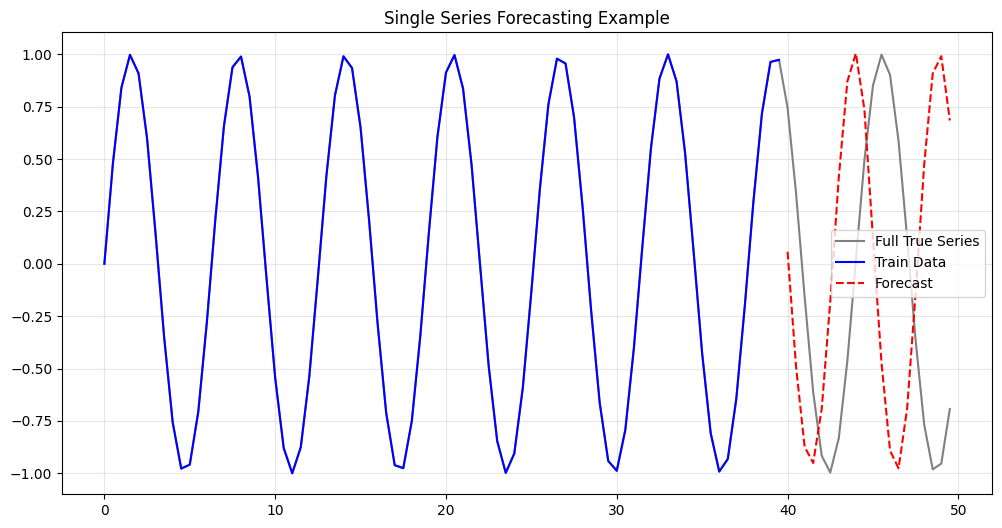

In [5]:
# Generate a sine wave as our data
time = np.arange(0, 50, 0.5)
y_single = np.sin(time)

# Split into train and test
train_data = y_single[:-20].reshape(1, -1)
print(train_data.shape)

# Fit the model
model_single = SetartreeForecaster(lag=10, max_depth=5)

# Get predictions
# We can either predict from the end of the training data (y=None)
# or provide the training data again as context.
predictions = model_single.iterative_forecast(train_data, prediction_horizon=20)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, y_single, label="Full True Series", color="gray")
plt.plot(time[:-20], train_data.flatten(), label="Train Data", color="blue")
plt.plot(time[-20:], predictions, label="Forecast", color="red", linestyle="--")
plt.title("Single Series Forecasting Example")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Example 4.2: Global Forecasting and Predicting an Unseen Series

Now for the main use case: training a single "global" model on multiple series, and then using it to forecast a completely new series it has never seen before. This highlights the model's ability to generalize.

Global model fitted on two series.
Generated predictions for the new, unseen series.


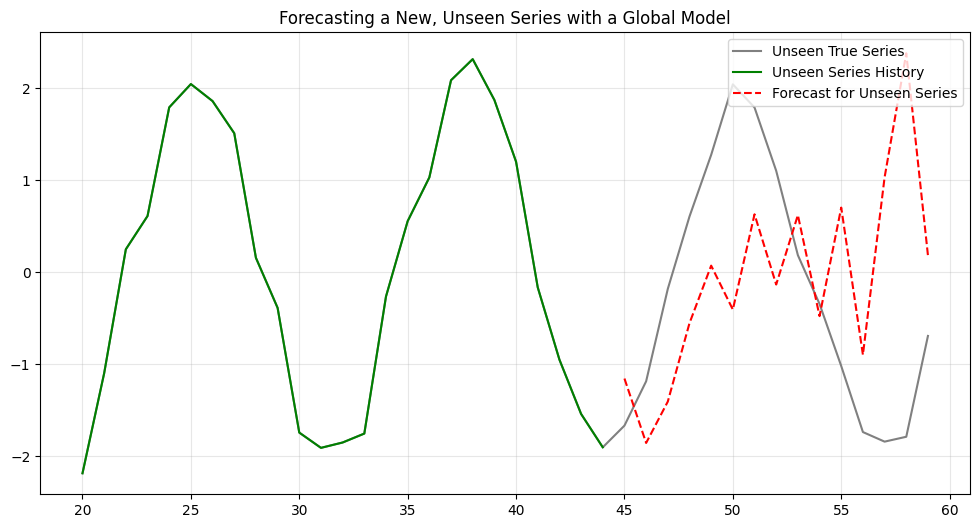

In [6]:
# 1. Create Training Data (two related series)
time_multi = np.arange(0, 40, 1)
y_multi_1 = 2 * np.sin(time_multi * 0.5) + np.random.normal(0, 0.2, 40)
y_multi_2 = 2 * np.cos(time_multi * 0.5) + np.random.normal(0, 0.2, 40)

# 2. Fit the Global Model
horizon = 15
global_model = SetartreeForecaster(lag=8, horizon=horizon, max_depth=4)
global_model.fit(y=y_multi_1, exog=y_multi_2)
print("Global model fitted on two series.")

# 3. Create a New, Unseen Series
time_new = np.arange(20, 60, 1)  # Different time range
y_new_unseen = 2 * np.sin(time_new * 0.5 + 1.5) + np.random.normal(0, 0.2, 40)
history_for_pred = y_new_unseen[:-15].reshape(1, -1)

# 4. Predict on the Unseen Series
y = history_for_pred
new_predictions = np.zeros(horizon)
for i in range(0, horizon):
    new_predictions[i] = global_model.predict(y)
    y = np.append(y, new_predictions[i])
print("Generated predictions for the new, unseen series.")

# 5. Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_new, y_new_unseen, label="Unseen True Series", color="gray")
plt.plot(
    time_new[:-15],
    history_for_pred.flatten(),
    label="Unseen Series History",
    color="green",
)
plt.plot(
    time_new[-15:],
    new_predictions,
    label="Forecast for Unseen Series",
    color="red",
    linestyle="--",
)
plt.title("Forecasting a New, Unseen Series with a Global Model")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Test on large scale Datasets

(temporal) see setar_experiments.py

current test on chaotic_logistic_dataset 

done: outline of code, first experiment

problem: 

1. the running time is extremely long (30min+ for fitting 100 time series). The paper present the training time of 0.09min for tree, so definitely needs speeding up. 
2. the accuracy is far away from the paper's result (also need to be checked)

## 6. SETAR-forest module

The `SetarforestForecaster` is an ensemble model that builds upon the SetartreeForecaster to improve prediction accuracy and robustness, based on the principles described in the original paper. The key idea is that a "forest" of diverse trees will often outperform a single tree by averaging out their individual errors.

#### Core Concepts:

1. Ensemble of Trees: 

The forest is composed of multiple individual SetartreeForecaster instances (controlled by the n_estimators parameter).

2. Bagging (Bootstrap Aggregation): 

To promote diversity, each tree in the forest is trained on a random subset of the time series from the full training panel. The bagging_fraction parameter controls the size of this subset. This helps to reduce variance and prevent overfitting.

3. Hyperparameter Randomization: 

Each tree is intentionally made different by initializing it with randomized hyperparameters. Specifically, the significance level, significance_divider, and error_threshold for the splitting logic are chosen from a uniform distribution for each tree. This ensures that the trees do not all split on the same criteria, further increasing diversity.

4. Averaged Prediction: 

When making a forecast, the forest gets a prediction from each of its internal trees and returns the simple average of these predictions.